# Exponential Model

This notebook contains the simplest model (an exponential) that captures the behavior of the virus responsible for covid.  It uses an exponential function

$$\textrm{Cumulative Infections} = \textrm{Initial Infections}\cdot e^{\textrm{Growth Rate}\cdot t}$$

It does not consider

- A reducing pool of susceptible individuals slowing the growth rate
- An social distancing behaviors in the future

It only finds the growth rate for the current US data and continues that trend into the future.

We are currently doubling our number of cases every 2.4 days and the growth rate appears steady.

If our social distancing strategies are effective, the slope of the dots will decrease showing a slowing of transmission.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import requests
import json

In [2]:
# get US positive observations from covidtracking.com
URL = 'https://covidtracking.com/api/us/daily'
r = requests.get(URL)
data = pd.read_json(json.dumps(r.json()))

# wrangle dates
data.index = data['date']
data.index = pd.to_datetime(data['date'], format='%Y%m%d')
del(data['date'])

# display data
data.tail()

,states,positive,negative,posNeg,pending,death,total
date,,,,,,,
2020-03-12,51,1315,7950,9265,673,36.0,9873
2020-03-13,51,1922,13513,15435,1130,39.0,16565
2020-03-14,51,2450,17107,19557,1236,49.0,20795
2020-03-15,51,3173,22548,25721,2242,60.0,27963
2020-03-16,56,4019,35840,39859,1691,71.0,41552


In [3]:
# perform exponential fit and create extrapolation

# create independent variable of days since start of data
days = (data.index - data.index[0]) / np.timedelta64(1, 'D')

# take log of independent variable
log_positives = np.log(data['positive'])

# find least-squares fit coefficients
beta, log_initial = np.polyfit(days, log_positives, 1)

# create vector of extrapolated positive cases
num_days = 20
time = np.arange(0, len(data.index) + num_days, 1)
extrapolated_positives = np.exp(log_initial) * np.exp(beta * time)

# put in pandas series with dates for easy plotting
extrapolation_dates = [data.index[0] + np.timedelta64(1, 'D') * t for t in time]
extrapolation = pd.Series(index=extrapolation_dates, data=extrapolated_positives)

In [4]:
# doubling time
np.log(2)/beta

2.3673202026439726

In [5]:
# ten-fold time
np.log(10)/beta

7.864067490757457

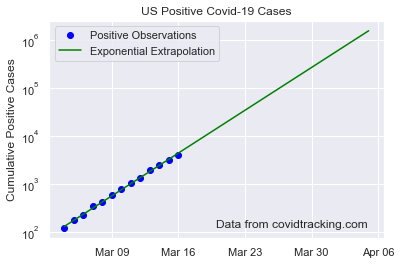

In [8]:
import seaborn as sns
from matplotlib.dates import MO
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

sns.set()
fig, ax = plt.subplots()
ax.plot(data.index, data['positive'], marker='o', linestyle='', color='blue', label='Positive Observations')
ax.plot(extrapolation.index, extrapolation, color='green', label='Exponential Extrapolation')

loc = mdates.WeekdayLocator(byweekday=MO)
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_title('US Positive Covid-19 Cases')
ax.set_yscale('log')
ax.legend()
ax.text(0.5, 0.05, 'Data from covidtracking.com', transform=ax.transAxes)
ax.grid(True)
ax.set_ylabel('Cumulative Positive Cases')
plt.savefig('covid-exponential.png')
plt.show()
